# Organ segmentation reproduction sandbox

## Contents

1. Imports
2. Testing out TensorBoard
3. Create the dataset
4. Define the model architecture
5. Train the model
6. View the results
7. Test the model
8. Reproduce the results


In [38]:
# Setup
import os
import numpy as np # For general mathematical operations
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # For plotting the results
from torchsummary import summary # For model summaries
from torch.utils.tensorboard import SummaryWriter # For writing into tensorboard
import nrrd # For reading and manipulating nrrd files
from glob import glob


# Testing out tensorboard <a id="TensorBoardTest"></a>

In [23]:
writer = SummaryWriter(comment="Tensorboard Test")
x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = -5 * x + 0.1 * torch.randn(x.size())

model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

def train_model(iter):
    for epoch in range(iter):
        y1 = model(x)
        loss = criterion(y1, y)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

train_model(10)
writer.flush()

Remove test run after recognising it works (CAREFUL)

In [24]:
%rm -r runs

# Create the dataset

In [93]:
structures = [
    "BrainStem",
    "Chiasm",
    "Mandible",
    "OpticNerve_L",
    "OpticNerve_R",
    "Parotid_L",
    "Parotid_R",
    "Submandibular_L",
    "Submandibular_R"
]

## A sample image

The images are 3D images of human heads. The segmentations are 3D images, where the wanted part is "highlighted". The range of the image values is [0,1].

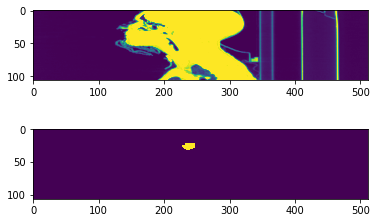

In [92]:

sample_fullimage, header_fullimage = nrrd.read("./data/raw/PDDCA-1.4.1_part1/0522c0001/img.nrrd")
sample_brainstem, header_brainstem = nrrd.read("./data/raw/PDDCA-1.4.1_part1/0522c0001/structures/BrainStem.nrrd")
fig, axs = plt.subplots(2,1)
axs[0].imshow(sample_fullimage[250,:,:][:,::-1].T, vmax=0.001)
axs[1].imshow(sample_brainstem[250,:,:][:,::-1].T, vmax=0.001)

In [171]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path

def pad_tensor(t, output_size=512):
    l, w, h = t.shape
    missing = output_size - l
    zeros = torch.zeros(size=(missing, w, h))
    t = torch.concat([t, zeros])
    return t

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, target_structure, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.target_structure = target_structure
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = Path(self.image_paths[idx])
        image_filepath = image_path / "img.nrrd"
        structure_filepath = image_path / "structures" / (self.target_structure + ".nrrd")

        image, _ = nrrd.read(image_filepath)
        structure, _ = nrrd.read(structure_filepath)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            structure = self.target_transform(structure)
        return image, structure

In [172]:
# Read the filenames

raw_1_img_filepaths = glob("./data/raw/PDDCA-1.4.1_part1/*")

train_transform = transforms.Compose([
            transforms.ToTensor(),
            pad_tensor,
        ])
# Create the dataset
train_set_brainstem = CustomImageDataset(
    raw_1_img_filepaths, 
    target_structure="BrainStem",
    transform=train_transform, 
    target_transform=train_transform, 
    )

# Define data loaders used to iterate through dataset
train_dataloader = DataLoader(train_set_brainstem, batch_size=8, shuffle=True)
#test_loader = DataLoader(test_data, batch_size=1000)


In [173]:
train_features, train_labels = next(iter(train_dataloader))

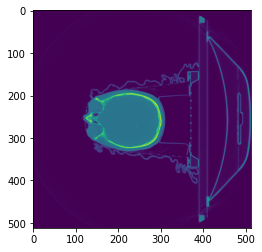

In [181]:
plt.imshow(train_features[0,100,:,:])

# Define the model

The model architecture as per the paper.

In [183]:
def conv_2x2d():
    pass

def conv_2x3d_coarse():
    pass

def conv_3d_fine():
    pass

class OrganNetRepro(torch.nn.Module):

    def __init__(self):
        """
        Initialize the network.
        """

        # 2D layers
        self.two_d_1 = conv_2x2d()
        self.two_d_2 = conv_2x2d()

        # Coarse 3D layers

        self.coarse_3d_1 = conv_2x3d_coarse()
        self.coarse_3d_2 = conv_2x3d_coarse()
        self.coarse_3d_3 = conv_2x3d_coarse()
        self.coarse_3d_4 = conv_2x3d_coarse()

        # Fine 3D block

        self.fine_3d_1 = conv_3d_fine()
        self.fine_3d_2 = conv_3d_fine()
        self.fine_3d_3 = conv_3d_fine()


        self.layers = [
            self.two_d_1,
            self.two_d_2,
            self.coarse_3d_1,
            self.coarse_3d_2,
            self.coarse_3d_3,
            self.coarse_3d_4,
            self.fine_3d_1,
            self.fine_3d_2,
            self.fine_3d_3,
        ]

    def forward():


        ## Part 1 (Left side)

        # Input to 2D layer 1 -> Output 1
        # Output 1 to pooling layer S(1,2,2) -> Output 2 # TODO what pooling is this?
        # Output 2 to coarse 3D layer 1 -> Output 3
        # Output 3 to pooling layer S(2,2,2) -> Output 4 # TODO what pooling?
        # Output 4 to Coarse 3D layer 2 -> Output 5
        # Output 5 to Fine 3D Layer 1 -> Output 6
        
        # Part 2 (Bottom, starting from the first Orange arrow)
        # Output 6 to Fine 3D Layer 2 -> Output 7
        # Output 7 to "Conv 1x1x1" layer 1 -> Output 8 # TODO Elaborate on the 1x1x1 layer
        # Concatenate Output 6 and Output 8 -> Output 9
        # Output 9 to Fine 3D Layer 3 -> Output 10
        
        # Part 3 (Right side, starting from the bottom right yellow arrow)
        # Output 10 to 1x1x1 layer 2 -> Output 11 # TODO still missing
        # Concatenate Output 11 and Output 5 -> Output 12
        # Output 12 to Coarse 3d layer 3 -> Output 13
        # Transpose Output 13 -> Output 14
        # Concatenate Output 14 and Output 3 -> Output 15
        # Output 15 to Coarse 3d Layer 4 -> Output 16
        # Concatenate Output 1 and Output 16 -> Output 17
        # Output 17 to 2D layer 2 -> Output 18
        # Output 18 to 1x1x1 layer 3 -> Final output

        

        pass
        
